In [2]:
# https://canvas.vu.nl/courses/72644/files/folder/Assignments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d


## Part 1: IRS

In [3]:
def standardized_maturities(zero_rates):
    """
    Standardize maturity indices for ECB data to yearly scaled indices.

    Parameters:
        zero_rates (pd.Series): Pandas Series containing zero rates with maturity indices.

    Returns:
        list: A list of standardized maturity values in years.

    This function standardizes the maturity indices provided in the ECB data to yearly scaled indices. It processes each
    maturity index, which can be in the format "X months" or "X years," and converts them into a yearly scale for
    consistent handling.
    """
    standardized_maturities = []
    for maturity in zero_rates.index:
        if 'month' in maturity:
            num_months = int(maturity.split()[0])
            standardized_maturities.append(num_months / 12.0)
        elif 'year' in maturity:
            num_years = int(maturity.split()[0])
            standardized_maturities.append(num_years)
        else:
            raise ValueError(f"Unrecognized maturity format: {maturity}")
    return standardized_maturities


In [4]:
usbond_df = pd.read_excel('data/usbond_data.xlsx')
bondtest_data = pd.read_excel('data/bondtest_data.xlsx')
european_zerorates = pd.read_excel('data/european_zerorates.xlsx')
european_zerorates = european_zerorates.set_index('Maturity')
european_zerorates =  european_zerorates['AAA rated']
european_zerorates.index = standardized_maturities(european_zerorates)

In [17]:
european_zerorates

0.25     3.783713
0.50     3.696803
0.75     3.578624
1.00     3.450661
2.00     3.012432
3.00     2.763111
4.00     2.647461
5.00     2.605361
6.00     2.601465
7.00     2.616947
8.00     2.641795
9.00     2.670548
10.00    2.700157
11.00    2.728900
12.00    2.755815
13.00    2.780391
14.00    2.802391
15.00    2.821747
16.00    2.838494
17.00    2.852731
18.00    2.864593
19.00    2.874235
20.00    2.881822
21.00    2.887517
22.00    2.891484
23.00    2.893878
24.00    2.894846
25.00    2.894526
26.00    2.893048
27.00    2.890532
28.00    2.887087
29.00    2.882815
30.00    2.877809
Name: AAA rated, dtype: float64

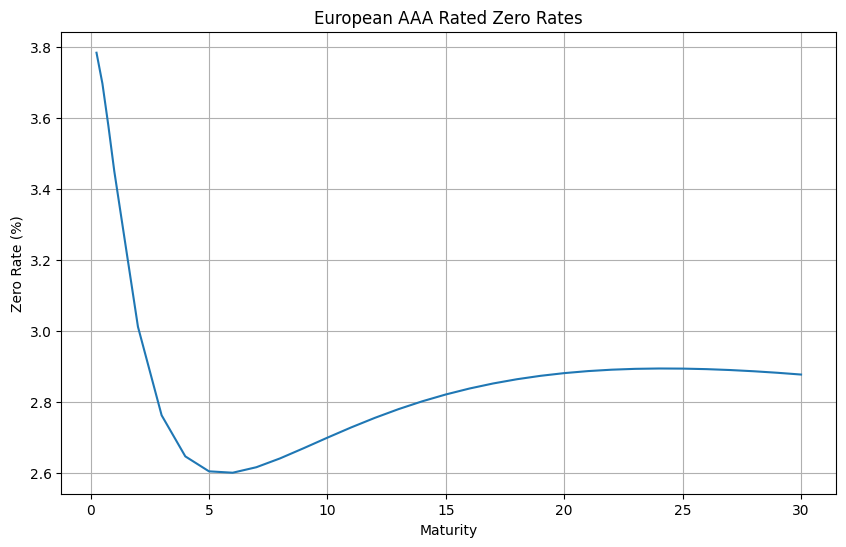

In [5]:
# Plotting
plt.figure(figsize=(10, 6))
european_zerorates.plot()
plt.title('European AAA Rated Zero Rates')
plt.xlabel('Maturity')
plt.ylabel('Zero Rate (%)')
plt.grid(True)
plt.show()

In [6]:
def get_euribordata():
    """
    Fetch Euribor rates data from an API.

    Returns:
        dict: A dictionary containing Euribor rates for different tenors.

    This function sends an API request to retrieve Euribor rates data and then extracts and organizes the rates
    for tenors of 3 months, 6 months, and 12 months into a dictionary. The function returns this dictionary.
    """
    url = "https://euribor.p.rapidapi.com/all"

    headers = {
        "X-RapidAPI-Key": "46bc3a6f18mshb2d07e9eb01ef29p1c2d78jsn578089492ef1",
        "X-RapidAPI-Host": "euribor.p.rapidapi.com"
    }

    EURIBOR = requests.get(url, headers=headers).json()
    
    euribor_rates = {
        '3months': EURIBOR['3months'],
        '6months': EURIBOR['6months'],
        '12months': EURIBOR['12months']
    }
    return euribor_rates

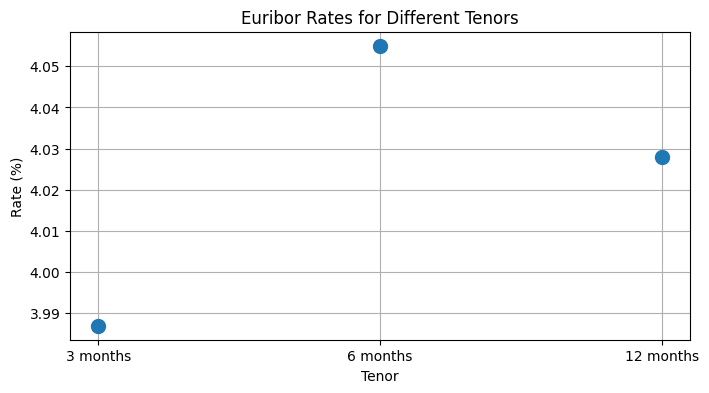

In [7]:
euribor_rates = get_euribordata()
tenors = ['3 months', '6 months', '12 months']
rates = [euribor_rates['3months'], euribor_rates['6months'], euribor_rates['12months']]

plt.figure(figsize=(8, 4))
plt.plot(tenors, rates, 'o', markersize=10)  # 'o' creates circular markers
plt.title('Euribor Rates for Different Tenors')
plt.xlabel('Tenor')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.show()

In [8]:
def __determine_paymentfrequency(payment_frequency):
    """
    Determine the Pandas frequency string and number of months for a given payment frequency.

    Parameters:
        payment_frequency (float): Payment frequency (e.g., 0.5 for semi-annual).

    Returns:
        tuple: A tuple containing the Pandas frequency string and the number of months in the frequency.

    This private function maps a payment frequency to a Pandas frequency string and returns it along with the
    corresponding number of months in that frequency. It is used to determine the frequency for date range generation.
    """
    if payment_frequency == 0.5:  # Semi-annual
        freq_str = '6M'
        months = 6
    elif payment_frequency == 0.25:  # Quarterly
        freq_str = '3M'
        months = 3
    elif payment_frequency == 1:  # Annual
        freq_str = '12M'
        months = 12
    else:
        raise ValueError(f"Unsupported payment frequency: {payment_frequency}")
    return freq_str, months


## Cashflows: 

In [9]:
def calculate_floating_cashflow(notional_amount, payment_dates, start_date, months, payment_frequency, reference_rate):
    """
    Calculate floating cash flows for an interest rate swap.

    Parameters:
        notional_amount (float): The initial notional amount.
        start_date (pd.Timestamp): The start date of the interest rate swap.
        end_date (pd.Timestamp): The end date of the interest rate swap.
        payment_frequency (float): Payment frequency (e.g., 0.5 for semi-annual).
        reference_rate (dict): Dictionary containing reference rates for different tenors.

    Returns:
        list: A list of floating cash flows.

    This function calculates floating cash flows for an interest rate swap with a reference rate. It determines payment
    dates based on the specified payment frequency, then computes the floating cash flows for each payment date,
    excluding the start date, using the corresponding reference rate for the given tenor.
    """

    floating_cashflows = []

    for date in payment_dates:
        if date != start_date:
            rate = reference_rate[f"{months}months"]
            floating_cash_flow = notional_amount * rate * payment_frequency
            floating_cashflows.append(floating_cash_flow)             

    return floating_cashflows


def calculate_fixed_cashflow(notional_amount, payment_dates, start_date, payment_frequency, fixed_rate):
    """
    Calculate fixed cash flows for an interest rate swap.

    Parameters:
        notional_amount (float): The initial notional amount.
        start_date (pd.Timestamp): The start date of the interest rate swap.
        end_date (pd.Timestamp): The end date of the interest rate swap.
        payment_frequency (float): Payment frequency (e.g., 0.5 for semi-annual).
        fixed_rate (float): The fixed interest rate for the swap.

    Returns:
        tuple: A tuple containing a list of fixed cash flows and payment dates.

    This function calculates fixed cash flows for an interest rate swap with a fixed rate. It determines payment dates
    based on the specified payment frequency, then computes the fixed cash flows for each payment date, excluding the
    start date, and returns them as a list along with the payment dates.
    """

    fixed_cash_flows = []

    for date in payment_dates:
        if date != start_date:
            fixed_cash_flow = notional_amount * fixed_rate * payment_frequency
            fixed_cash_flows.append(fixed_cash_flow)
    
    return fixed_cash_flows, payment_dates


def discount_cash_flows(cash_flows, payment_dates, zero_curve, payment_frequency):
    """
    Calculate the discounted cash flows for a given set of cash flows and payment dates using a zero curve.

    Parameters:
        cash_flows (list): List of cash flow values.
        payment_dates (list): List of payment dates corresponding to the cash flows.
        zero_curve (dict): Dictionary containing zero rates for various maturities.
        payment_frequency (float): Payment frequency (e.g., 0.5 for semi-annual).

    Returns:
        float: The sum of the discounted cash flows.
    """

    discounted_cash_flows = []
    start_date = payment_dates[0]

    # Interpolate the zero rates for the cash flow dates
    interpolated_rates = interpolating_zero_rate(zero_curve, payment_dates)
    for cash_flow, rate, date in zip(cash_flows, interpolated_rates, payment_dates):
        ttm = (date - start_date).days / 365.0  # Time to maturity in years
        discount_factor = np.exp(-rate * ttm / payment_frequency)
        discounted_cash_flows.append(cash_flow * discount_factor)

    return sum(discounted_cash_flows)    

## Discount rates:

In [10]:
def interpolating_zero_rate(zero_curve, payment_dates):
    """
    Interpolate zero rates for a list of payment dates using a zero curve.

    Parameters:
        zero_curve (pd.Series): A Pandas Series containing zero rates for various maturities.
        payment_dates (list): List of payment dates corresponding to the zero rate interpolation.

    Returns:
        np.array: An array of interpolated zero rates for the provided payment dates.

    This function interpolates zero rates for a list of payment dates based on a given zero curve. It calculates the
    time to maturity in years for each payment date, then uses interpolation to estimate the zero rates for those
    dates. The function returns an array of interpolated zero rates.
    """
    
    start_date = payment_dates[0]
    years_to_maturity = (payment_dates - start_date).total_seconds() / (365 * 24 * 60 * 60)
    interpolating_function = interp1d(zero_curve.index, zero_curve, fill_value="extrapolate", bounds_error=False)
    interpolated_rates = interpolating_function(years_to_maturity)

    return interpolated_rates

def determine_discount_rate(payment_frequency, yield_curve, one_curve=True):
    """
    Determine discount rates based on yield curve and payment frequency.

    Parameters:
        payment_frequency (float): Payment frequency (e.g., 0.25 for quarterly, 0.5 for semi-annual, 1 for annual).
        yield_curve (dict): Dictionary containing yield curve data, including zero rates and Euribor rates.
        one_curve (bool): Boolean flag to indicate whether to use a single curve or two curves.

    Returns:
        list or tuple: List of zero rates or tuple of zero rates and floating discount rates.

    This function determines discount rates based on the provided yield curve data and payment frequency.
    If 'one_curve' is True, it returns the zero rates for the specified payment frequency.
    If 'one_curve' is False, it calculates interpolated zero rates and floating discount rates for the given
    payment frequency and returns a tuple containing zero rates and floating discount rates.
    """
    supported_frequencies = [0.25, 0.5, 1.0]
    
    if one_curve:
        zero_rates = yield_curve['zero_rate']
        if payment_frequency in supported_frequencies:
            return zero_rates
        else:
            raise ValueError("Unsupported payment frequency. Only 0.25 (quarterly), 0.5 (semi-annual), and 1.0 (annual) are supported.")
    else:
        zero_rates = yield_curve['zero_rate']
        euribor_rates = yield_curve['euribor']

        supported_frequencies = [0.25, 0.5, 1.0]  # Supported payment frequencies
        if payment_frequency in supported_frequencies:
            return zero_rates, euribor_rates
        
        # Hier kunnen we nog andere frequencies toevoegen. 

        # # Interpolate zero rates and Euribor rates
        # interpolated_zero_rates = np.interp(np.arange(0.25, max(zero_rates.keys()) + 0.25, payment_frequency), list(zero_rates.keys()), list(zero_rates.values()))
        # interpolated_euribor_rates = np.interp(np.arange(0.25, max(euribor_rates.keys()) + 0.25, payment_frequency), list(euribor_rates.keys()), list(euribor_rates.values()))
        # # Calculate floating discount rates
        # floating_discount_rates = get_floating_discount_rates(payment_frequency, euribor_rates)
        # return yield_curve['zero_rate'], floating_discount_rates

In [11]:
# def get_floating_discount_rates(payment_frequency, euribor_rates):
#     """
#     Calculate floating discount rates based on Euribor rates for a given payment frequency.

#     Parameters:
#         payment_frequency (float): Payment frequency (e.g., 0.5 for semi-annual).
#         euribor_rates (dict): Dictionary containing Euribor rates for different tenors.

#     Returns:
#         list: A list of floating discount rates.

#     This function calculates the corresponding floating discount rates for each Euribor rate in the provided dictionary,
#     based on the given payment frequency. It stores these rates in a list and returns the list.
#     """
    
#     floating_discount_rates = []
    
#     for tenor, rate in euribor_rates.items():
#         # Calculate the corresponding discount rate for each Euribor rate
#         discount_rate = 1 / ((1 + rate) ** (1/payment_frequency))
#         floating_discount_rates.append(discount_rate)
    
#     return floating_discount_rates

def value_interest_rate_swap(zero_rate, notional_amount, start_date, end_date, payment_frequency, fixed_rate, swap_type='fixed_vs_floating', amortization_schedule=None, one_curve=True):
    """
    Calculate the net present value (NPV) of an interest rate swap.

    Parameters:
        zero_rate (pd.Series or float): Zero rates for discounting or a single zero rate if 'one_curve' is True.
        notional (float): The initial notional amount.
        start_date (pd.Timestamp): The start date of the interest rate swap.
        end_date (pd.Timestamp): The end date of the interest rate swap.
        payment_frequency (float): Payment frequency (e.g., 0.25 for quarterly, 0.5 for semi-annual, 1 for annual).
        fixed_rate (float): The fixed interest rate for the swap.
        swap_type (str, optional): Type of interest rate swap (default is 'fixed_vs_floating').
        amortization_schedule (list, optional): Amortization schedule if applicable (default is None).
        one_curve (bool, optional): Boolean flag to indicate whether to use a single curve or two curves (default is True).

    Returns:
        float: The net present value (NPV) of the interest rate swap.

    This function calculates the NPV of an interest rate swap based on the provided parameters. It takes into account the
    type of swap, payment frequency, and whether to use a single curve or two curves for discounting.
    """
    yield_curve = {'zero_rate': zero_rate, 'euribor': get_euribordata()}
        
    freq_str, months = __determine_paymentfrequency(payment_frequency)
    payment_dates = pd.date_range(start=start_date, end=end_date, freq=freq_str)

    if one_curve: 
        discount_rate = determine_discount_rate(payment_frequency, yield_curve, one_curve=True)
    else: 
        zero_rate, euribor_rates = determine_discount_rate(payment_frequency, yield_curve, one_curve=False)
        floating_cash_flows = calculate_floating_cashflow(notional_amount, payment_dates, start_date, months, payment_frequency, euribor_rates)
        discounted_floating = discount_cash_flows(floating_cash_flows, payment_dates, zero_rate, payment_frequency)

    fixed_cash_flows = calculate_fixed_cashflow(notional_amount, payment_dates, start_date, payment_frequency, fixed_rate)
    discounted_fixed = discount_cash_flows(fixed_cash_flows[0], payment_dates, zero_rate if not one_curve else discount_rate, payment_frequency)
    
    npv = discounted_fixed - discounted_floating if not one_curve else discounted_fixed
    
    return npv

In [27]:
# Common parameters
notional_amount = 100
start_date = pd.to_datetime('2023-01-01')
payment_frequency = 0.5  # Semi-annual payments
fixed_rate = 0.03  # 3% fixed rate

def create_amortization_schedule(start_date, end_date, notional_amount, final_notional, payment_frequency):
    freq_rt = __determine_paymentfrequency(payment_frequency)[0]
    amortization_dates = pd.date_range(start=start_date, end=end_date, freq=freq_rt)
    num_periods = len(amortization_dates)
    amortization_step = (notional_amount - final_notional) / (num_periods - 1)
    notional_amounts = [notional_amount - i * amortization_step for i in range(num_periods)]
    return dict(zip(amortization_dates, notional_amounts))

def adjust_rates(df, basis_points): 
    """"Assignment 1 SPFII Derivatives.pdf"
    
    """

    adjustments = basis_points/1000 #to decimals
    return df + adjustments

In [41]:
Scenarios = {}

# Scenario 1: 
end_date_1 = start_date + pd.DateOffset(years=2)
amortization_schedule_1 = create_amortization_schedule(start_date, end_date_1, notional_amount, 50, payment_frequency)
Scenarios['scenario_1'] = value_interest_rate_swap(european_zerorates, notional_amount, start_date, end_date_1, payment_frequency, fixed_rate, swap_type='fixed_vs_floating', amortization_schedule=amortization_schedule_1, one_curve=True)

# Scenario 2: 
Scenarios['scenario_2'] = {}

# For 5-year and 7 year swap
end_date_2_5yr = start_date + pd.DateOffset(years=5)
amortization_schedule_2_5yr = create_amortization_schedule(start_date, end_date_2_5yr, notional_amount, 50, payment_frequency)
amortization_schedule_list = [None, amortization_schedule_2_5yr] 
adjust_rates_list = [0, 25,50, 100, 150]
short_term_years = [5, 7]

for year in short_term_years:
    Scenarios['scenario_2'][f'{year}yr'] = {}

    end_date_2 = start_date + pd.DateOffset(years=year)
    amortization_schedule_2 = create_amortization_schedule(start_date, end_date_2, notional_amount, 50, payment_frequency)
    amortization_schedule_list = [None, amortization_schedule_2] 

    for rate in adjust_rates_list:
        adjusted_rates = adjust_rates(european_zerorates.copy(), rate)
        Scenarios['scenario_2'][f'{year}yr'][f'{rate}%'] = {}
        for schedule in amortization_schedule_list:
            if schedule == None:
                Scenarios['scenario_2'][f'{year}yr'][f'{rate}%']['No'] = value_interest_rate_swap(adjusted_rates, notional_amount, start_date, end_date_2, payment_frequency, fixed_rate, swap_type='fixed_vs_floating', amortization_schedule=schedule, one_curve=True)
            else: 
                Scenarios['scenario_2'][f'{year}yr'][f'{rate}%']['Yes'] = value_interest_rate_swap(adjusted_rates, notional_amount, start_date, end_date_2, payment_frequency, fixed_rate, swap_type='fixed_vs_floating', amortization_schedule=schedule, one_curve=True)

# Scneario 3: 
Scenarios['scenario_3'] = {}

for years in range(8, 31):
    end_date_3 = start_date + pd.DateOffset(years=years)
    amortization_schedule_3 = create_amortization_schedule(start_date, end_date_3, notional_amount, 50, payment_frequency)

    Scenarios['scenario_3'][f"{years}yr"] = {}
    rate_changes_bp = [-200, -100, 0, 100, 200]  # -2% (-200 bp), -1% (-100 bp), 0%, +1% (+100 bp), +2% (+200 bp)
    
    for change_bp in rate_changes_bp:
        adjusted_rates = adjust_rates(european_zerorates.copy(), change_bp)
        scenario_key = f"{change_bp/10:+.0f}%"  # e.g., "+100%", "-100%"
        Scenarios['scenario_3'][f"{years}yr"][scenario_key] = value_interest_rate_swap(adjusted_rates, notional_amount, start_date, end_date_3, payment_frequency, fixed_rate, swap_type='fixed_vs_floating', amortization_schedule=amortization_schedule_3, one_curve=True)

In [44]:
# Plot scenario 3: 

# Prepare data for plotting
maturities = range(8, 31)
rate_changes = [-200, -100, 0, 100, 200]
for years in range(8, 31):
    for change in rate_changes:
        swap_values = [Scenarios['scenario_3'][f'{year}yr'][change] for year in maturities]
        plt.plot(maturities, swap_values, label=change)

plt.xlabel('Maturity (Years)')
plt.ylabel('Swap Value')
plt.title('Swap Value vs Maturity with Different Zero Curve Adjustments')
plt.legend()
plt.show()

KeyError: -200

In [40]:
Scenarios

{'scenario_1': 1.5399002750707318,
 'scenario_2': {'5yr': {'0%': {'No': 1.539909837007399,
    'Yes': 1.539909837007399},
   '25%': {'No': 1.5388906625839152, 'Yes': 1.5388906625839152},
   '50%': {'No': 1.5378986245875788, 'Yes': 1.5378986245875788},
   '100%': {'No': 1.5359928566916392, 'Yes': 1.5359928566916392},
   '150%': {'No': 1.5341865823704228, 'Yes': 1.5341865823704228}},
  '7yr': {'0%': {'No': 1.5399098370151478, 'Yes': 1.5399098370151478},
   '25%': {'No': 1.5388906625899372, 'Yes': 1.5388906625899372},
   '50%': {'No': 1.537898624592259, 'Yes': 1.537898624592259},
   '100%': {'No': 1.5359928566944663, 'Yes': 1.5359928566944663},
   '150%': {'No': 1.5341865823721312, 'Yes': 1.5341865823721312}}},
 'scenario_3': {'8yr': 1.539909837015148,
  '9yr': 1.539909837015148,
  '10yr': 1.539909837015148,
  '11yr': 1.539909837015148,
  '12yr': 1.539909837015148,
  '13yr': 1.539909837015148,
  '14yr': 1.539909837015148,
  '15yr': 1.539909837015148,
  '16yr': 1.539909837015148,
  '17yr':

## Bootstrap method: 
- Currently not sure which bonds to use to find zero rates

In [14]:
def bootstrap_yield_curve(df, payments_per_year):
    """
    Bootstrap method to determine the zero curve based on bond data.

    Parameters:
        df (pd.DataFrame): DataFrame containing bond data with columns 'Time to Maturity', 'Bond price',
            'Bond Principal', 'Coupon per year'.
        payments_per_year (int): Number of coupon payments per year.

    Returns:
        dict: A dictionary containing zero rates for various maturities.

    This function uses the bootstrap method to determine the zero curve based on bond data provided in a DataFrame.
    It calculates zero rates for different maturities by iterating through the bonds and considering their cash flows.
    """
    zero_rates = {}

    for index, bond in df.iterrows():
        TTM = bond['Time to Maturity']
        price = bond['Bond price']
        principle = bond['Bond Principal']
        coupon_rate = bond['Coupon per year'] * payments_per_year

        if coupon_rate == 0:
            # Zero-coupon bond
            zero_rate = -np.log(price / principle) * 1 / TTM
        else:
            # Coupon-bearing bond
            total_discounted_cash_flow = []
            for t in np.arange(0.5, TTM + 0.5, 0.5):
                cash_flow = coupon_rate

                if t in zero_rates:
                    discount_factor = np.exp(-zero_rates[t] * t)
                    total_discounted_cash_flow.append(cash_flow * discount_factor)

            coupon_payment = np.sum(total_discounted_cash_flow)

            zero_rate = -np.log((price - coupon_payment) / (principle + coupon_rate)) * (1 / TTM)

        zero_rates[TTM] = zero_rate
        df.loc[index, 'zero_rate'] = zero_rate

    return zero_rates


bootstrap_yield_curve(bondtest_data, 0.5)

{0.5: 0.10469296074441824,
 1.0: 0.10536051565782628,
 1.5: 0.10680926388170528,
 2.0: 0.10808027549746793}